In [1]:
## Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, max, min, countDistinct, sum, round
import geopandas as gpd

## Set up PySpark environment
from pyspark.sql import SparkSession

In [2]:
## Initialize the SparkSession
# appName is the name of the application
# getOrCreate() creates a new session or retrieves an existing one
spark = SparkSession.builder \
    .appName("PySpark project 2") \
        .getOrCreate()

## Verify that SparkSession is created
spark

25/04/18 13:52:43 WARN Utils: Your hostname, Zipcoders-MacBook-Pro-5.local resolves to a loopback address: 127.0.0.1; using 192.168.3.155 instead (on interface en0)
25/04/18 13:52:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 13:52:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Look at Population by State

In [3]:
try:
    zip_df = spark.read.csv ('../data/zip_code_demographics.csv', header=True, inferSchema=True)
    print('Data loaded successfully')
except Exception as e:
    print(f'Error loading data: {e}')

Data loaded successfully


In [51]:
zip_df.show(10)

+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
| zip|     lat|      lng|        city|state_id|   state_name|population|density|county_name|po_box|      dist_highway|dist2_large_airport|dist2_medium_airport|   dist_to_shore|number_of_business|adjusted_gross_income|total_income_amount|number_of_returns|
+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
|1001|42.06262|-72.62521|      Agawam|      MA|Massachusetts|     16088|  550.1|    Hampden|     0|  1.38703489958776|   106.145765467407|    12.9462123500772|93.0492507357679|               438|               598807|           6047

In [5]:
zip_df.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: double (nullable = true)
 |-- county_name: string (nullable = true)
 |-- po_box: integer (nullable = true)
 |-- dist_highway: double (nullable = true)
 |-- dist2_large_airport: double (nullable = true)
 |-- dist2_medium_airport: double (nullable = true)
 |-- dist_to_shore: double (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)
 |-- number_of_returns: integer (nullable = true)



In [48]:
zip_pop_df = zip_df.select('state_id','state_name','population').groupBy('state_id','state_name').agg(sum('population').alias("total_population"))
zip_pop_df.show(10)

+--------+--------------------+----------------+
|state_id|          state_name|total_population|
+--------+--------------------+----------------+
|      MT|             Montana|         1511394|
|      NC|      North Carolina|        12419438|
|      MD|            Maryland|         7224056|
|      CO|            Colorado|         6617159|
|      CT|         Connecticut|         3819343|
|      IL|            Illinois|        13819331|
|      WY|             Wyoming|         1182453|
|      NJ|          New Jersey|         9823423|
|      DE|            Delaware|         1372445|
|      DC|District of Columbia|         1207283|
+--------+--------------------+----------------+
only showing top 10 rows



In [50]:
zip_pop_df.orderBy(col("total_population").desc()).show(5)

+--------+------------+----------------+
|state_id|  state_name|total_population|
+--------+------------+----------------+
|      CA|  California|        44183935|
|      TX|       Texas|        33411444|
|      NY|    New York|        23903874|
|      FL|     Florida|        23007226|
|      PA|Pennsylvania|        16557706|
+--------+------------+----------------+
only showing top 5 rows



In [7]:
zip_pop_pd = zip_pop_df.toPandas()

In [8]:
shape_path = '../data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
shape = gpd.read_file(shape_path)
print(shape.columns)


Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [46]:
shape_for_graph = pd.merge(
    left = shape,
    right = zip_pop_pd,
    left_on = 'NAME',
    right_on ='state_name',
    how = 'left'
)


In [14]:
shape_for_graph.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'state_id', 'state_name',
       'total_population'],
      dtype='object')

In [18]:
shape_for_graph2 = shape_for_graph.dropna()
shape_for_graph2.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'state_id', 'state_name',
       'total_population'],
      dtype='object')

In [54]:
shape_for_graph2 = shape_for_graph2[~shape_for_graph2['NAME'].isin(['Alaska', 'Hawaii','Puerto Rico'])]

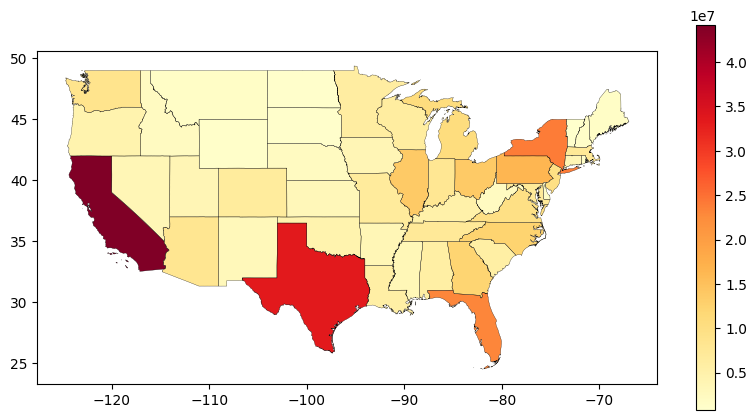

In [55]:
ax = shape_for_graph2.boundary.plot(edgecolor ='black', linewidth=0.2, figsize=(10,5))
shape_for_graph2.plot(ax=ax, column="total_population", legend=True, cmap='YlOrRd')
plt.show()

## Pop by state